In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report)
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')


In [20]:
# Load dataset
df = pd.read_csv('Campus_Selection.csv')
print("Initial Data Shape:", df.shape)
df.head()


Initial Data Shape: (215, 14)


,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


EDA & Preprocessing

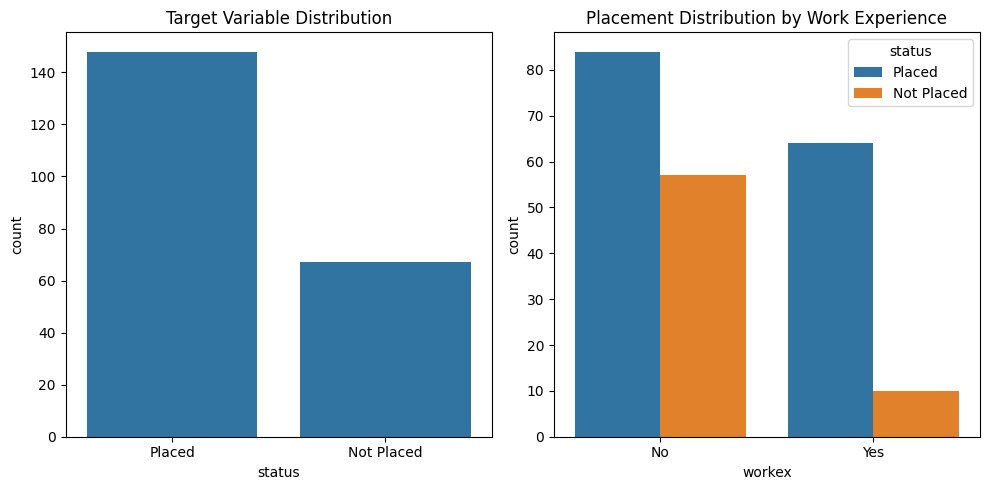

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x='status', data=df)
plt.title('Target Variable Distribution')

plt.subplot(1,2,2)
sns.countplot(x='workex', hue='status', data=df)
plt.title('Placement Distribution by Work Experience')
plt.tight_layout()
plt.show()


In [22]:
# Handle missing values
df['mba_p'] = df['mba_p'].fillna(df.groupby('status')['mba_p'].transform('median'))

In [23]:
# Encode target variable
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

In [24]:
# Split data
X = df.drop('status', axis=1)
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [25]:
# Preprocessing pipeline
cat_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
num_features = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])


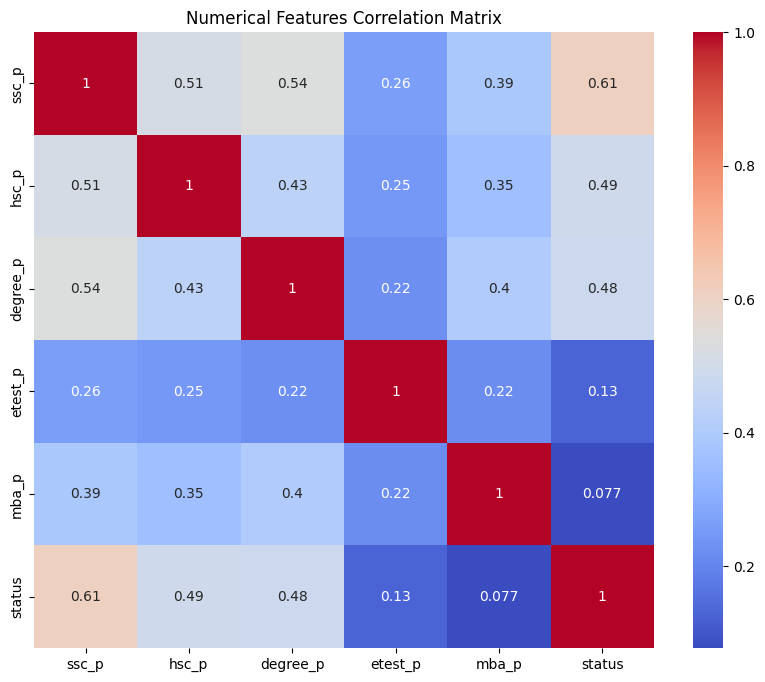

In [26]:
# Correlation Matrix
num_df = df[num_features + ['status']]
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Numerical Features Correlation Matrix')
plt.show()

Model Development with Hyperparameter Tuning

In [27]:
# Define models with extended hyperparameters
models = {
    'Logistic Regression': {'model': LogisticRegression(max_iter=1000, class_weight='balanced'),'params': {'classifier__C': [0.01, 0.1, 1, 10],'classifier__solver': ['liblinear', 'saga'] }},
    'Random Forest': {'model': RandomForestClassifier(class_weight='balanced'),'params': {'classifier__n_estimators': [100, 200],'classifier__max_depth': [None, 5, 10],'classifier__min_samples_split': [2, 5] }},
    'SVM': {'model': SVC(class_weight='balanced', probability=True),'params': {'classifier__C': [0.1, 1, 10],'classifier__kernel': ['linear', 'rbf'] } }
}


In [28]:
# Train and tune models
best_models = {}
for name, config in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor),('classifier', config['model'])])
    
    grid = GridSearchCV(pipeline, config['params'], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = {'model': grid.best_estimator_,'params': grid.best_params_,'score': grid.best_score_}
    print(f"{name} Best Parameters: {grid.best_params_}")
    print(f"Best Validation F1: {grid.best_score_:.4f}\n")


Logistic Regression Best Parameters: {'classifier__C': 1, 'classifier__solver': 'liblinear'}
Best Validation F1: 0.8831

Random Forest Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Validation F1: 0.8910

SVM Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Best Validation F1: 0.9122



Model Evaluation & Interpretation

In [29]:
# Evaluate models
results = []
for name, model in best_models.items():
    estimator = model['model']
    y_pred = estimator.predict(X_test)
    
    # Metrics
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    })

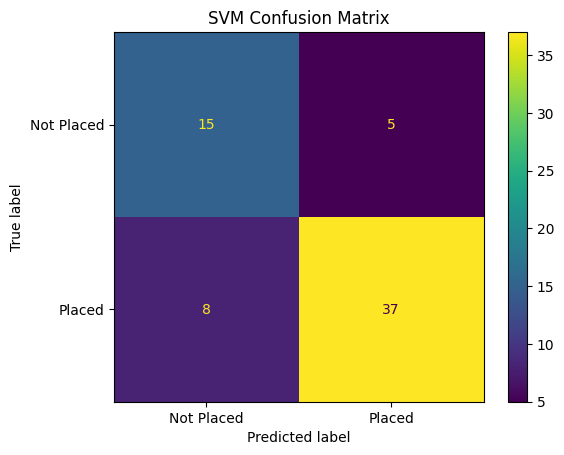

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Placed', 'Placed'])
disp.plot()
plt.title(f'{name} Confusion Matrix')
plt.show()

In [31]:
# Feature Importance (for tree-based)
if name == 'Random Forest':
        feature_names = (num_features + 
                        list(estimator.named_steps['preprocessor']
                             .named_transformers_['cat']
                             .get_feature_names_out(cat_features)))
        importances = estimator.named_steps['classifier'].feature_importances_
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=fi_df.head(10))
        plt.title('Top 10 Feature Importances (Random Forest)')
        plt.show()

In [32]:
# Results DataFrame
results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Performance Comparison:")
print(results_df)



Model Performance Comparison:
                     Accuracy  Precision    Recall        F1
Model                                                       
Logistic Regression  0.830769   0.904762  0.844444  0.873563
Random Forest        0.846154   0.843137  0.955556  0.895833
SVM                  0.800000   0.880952  0.822222  0.850575


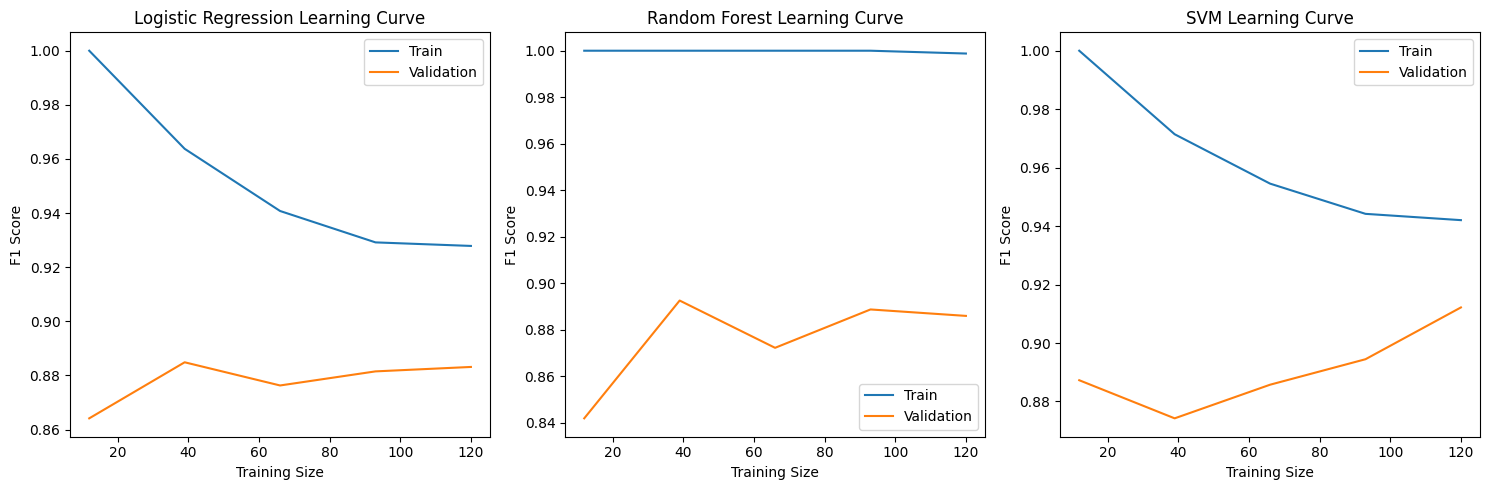

In [33]:
#Learning Curves
plt.figure(figsize=(15,5))
for i, (name, model) in enumerate(best_models.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        model['model'], X_train, y_train, cv=5, scoring='f1',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    
    plt.subplot(1,3,i+1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend()
plt.tight_layout()
plt.show()

In [34]:
# Create Voting Classifier
voting = VotingClassifier(
    estimators=[(name, model['model']) for name, model in best_models.items()],
    voting='soft'
)

voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)


In [35]:
# Evaluate
voting_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_voting),
    'Precision': precision_score(y_test, y_pred_voting),
    'Recall': recall_score(y_test, y_pred_voting),
    'F1': f1_score(y_test, y_pred_voting)
}

print("\nVoting Classifier Performance:")
print(pd.DataFrame([voting_metrics], index=['Voting Classifier']))


Voting Classifier Performance:
                   Accuracy  Precision    Recall        F1
Voting Classifier       0.8   0.847826  0.866667  0.857143


In [36]:
final_results = pd.concat([results_df, 
                         pd.DataFrame([voting_metrics], index=['Voting'])])
final_results.style.background_gradient(cmap='Blues', axis=0)

,Accuracy,Precision,Recall,F1
Logistic Regression,0.830769,0.904762,0.844444,0.873563
Random Forest,0.846154,0.843137,0.955556,0.895833
SVM,0.800000,0.880952,0.822222,0.850575
Voting,0.800000,0.847826,0.866667,0.857143


<Figure size 1000x600 with 0 Axes>

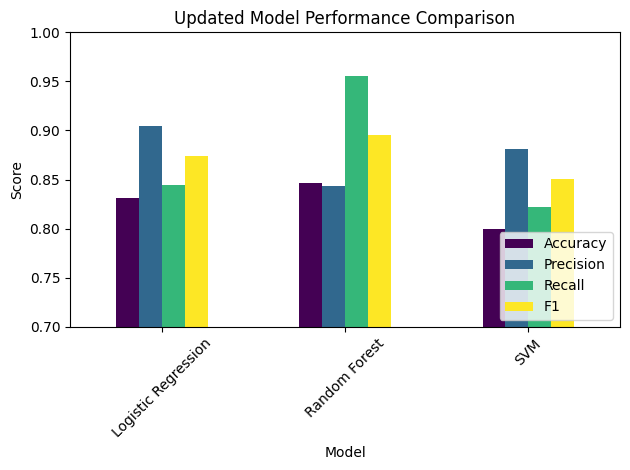

In [37]:
# Update the performance plot with correct metrics
plt.figure(figsize=(10,6))
results_df.plot(kind='bar', rot=45, colormap='viridis')
plt.title('Updated Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()